In [1]:
### BASIC INFO AND NOTES ON THE DATASET ###

# no missing data in any column

# age in years

# sex
# (1 = male; 0 = female)

# cp
# chest pain type

# trestbps
# resting blood pressure (in mm Hg on admission to the hospital)

# chol
# serum cholestoral in mg/dl

# fbs
# (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)

# restecg
# resting electrocardiographic results

# thalach
# maximum heart rate achieved

# exang
# exercise induced angina (1 = yes; 0 = no)

# oldpeak
# ST depression induced by exercise relative to rest

# slope
# the slope of the peak exercise ST segment

# ca
# number of major vessels (0-3) colored by flourosopy

# thal
# 3 = normal; 6 = fixed defect; 7 = reversable defect

# target
# 1 or 0 

In [2]:
import pandas as pd

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python

#load packages
import sys #access to system parameters https://docs.python.org/3/library/sys.html
print("Python version: {}". format(sys.version))

import pandas as pd #collection of functions for data processing and analysis modeled after R dataframes with SQL like features
print("pandas version: {}". format(pd.__version__))

import matplotlib #collection of functions for scientific and publication-ready visualization
print("matplotlib version: {}". format(matplotlib.__version__))

import numpy as np #foundational package for scientific computing
print("NumPy version: {}". format(np.__version__))

import scipy as sp #collection of functions for scientific computing and advance mathematics
print("SciPy version: {}". format(sp.__version__)) 

import IPython
from IPython import display #pretty printing of dataframes in Jupyter notebook
print("IPython version: {}". format(IPython.__version__)) 

import sklearn #collection of machine learning algorithms
print("scikit-learn version: {}". format(sklearn.__version__))

#misc libraries
import random
import time


#ignore warnings
import warnings
warnings.filterwarnings('ignore')
print('-'*25)


Python version: 3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
pandas version: 0.25.1
matplotlib version: 3.1.1
NumPy version: 1.16.5
SciPy version: 1.3.1
IPython version: 7.8.0
scikit-learn version: 0.21.3
-------------------------


In [4]:
# PIP INSTALLED XGBOOST BECAUSE APPARENTLY I DIDN'T HAVE IT
# pip install xgboost

In [5]:
#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.plotting import scatter_matrix

#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

In [6]:
hdata = pd.read_csv('C:/Users/kovus/Documents/Projects/Data/heart.csv')

In [7]:
#preview data
hdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null int64
target      303 non-null int64
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [8]:
hdata.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [9]:
hdata.tail()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0
302,57,0,1,130,236,0,0,174,0,0.0,1,1,2,0


In [10]:
hdata.sample(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
275,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
257,50,1,0,144,200,0,0,126,1,0.9,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
78,52,1,1,128,205,1,1,184,0,0.0,2,0,2,1
118,46,0,1,105,204,0,1,172,0,0.0,2,0,2,1
34,51,1,3,125,213,0,0,125,1,1.4,2,1,2,1
280,42,1,0,136,315,0,1,125,1,1.8,1,0,1,0
10,54,1,0,140,239,0,1,160,0,1.2,2,0,2,1
233,64,1,0,120,246,0,0,96,1,2.2,0,1,2,0
102,63,0,1,140,195,0,1,179,0,0.0,2,2,2,1


In [30]:
hdata.describe(include = 'all')

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,age_bin
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,297
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(50, 60]"
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,129
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554,NaN
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835,NaN
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000,NaN
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000,NaN
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000,NaN


In [13]:
hdata.nunique()

age          41
sex           2
cp            4
trestbps     49
chol        152
fbs           2
restecg       3
thalach      91
exang         2
oldpeak      40
slope         3
ca            5
thal          4
target        2
dtype: int64

In [14]:
###CREATE: Feature Engineering for train and test/validation dataset

#Age Bins/Buckets using cut or value bins: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.cut.html
hdata['age_bin'] = pd.cut(hdata['age'], [20, 30, 40, 50, 60, 70])

In [15]:
hdata.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,age_bin
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1,"(60, 70]"
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1,"(30, 40]"
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1,"(40, 50]"
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1,"(50, 60]"
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1,"(50, 60]"


In [16]:
hdata[['sex', 'target']].groupby('sex', as_index=False).mean()

,sex,target
0,0,0.750000
1,1,0.449275


In [17]:
[hdata.nunique()!=2]

[age          True
 sex         False
 cp           True
 trestbps     True
 chol         True
 fbs         False
 restecg      True
 thalach      True
 exang       False
 oldpeak      True
 slope        True
 ca           True
 thal         True
 target      False
 age_bin      True
 dtype: bool]

In [18]:
# EXPLORATORY ANALYSIS WITH STATISTICS
#Discrete Variable Correlation by Target using
#group by aka pivot table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html
for col in hdata.columns:
    if hdata[col].nunique() < 5 and col != 'target':
        print('Target Correlation by:', col)
        print(hdata[[col, 'target']].groupby(col, as_index=False).mean())
        print('-'*10, '\n')

Target Correlation by: sex
   sex    target
0    0  0.750000
1    1  0.449275
---------- 

Target Correlation by: cp
   cp    target
0   0  0.272727
1   1  0.820000
2   2  0.793103
3   3  0.695652
---------- 

Target Correlation by: fbs
   fbs    target
0    0  0.550388
1    1  0.511111
---------- 

Target Correlation by: restecg
   restecg    target
0        0  0.462585
1        1  0.631579
2        2  0.250000
---------- 

Target Correlation by: exang
   exang    target
0      0  0.696078
1      1  0.232323
---------- 

Target Correlation by: slope
   slope    target
0      0  0.428571
1      1  0.350000
2      2  0.753521
---------- 

Target Correlation by: thal
   thal    target
0     0  0.500000
1     1  0.333333
2     2  0.783133
3     3  0.239316
---------- 



In [19]:
#using crosstabs: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.crosstab.html
for col in hdata.columns:
    if hdata[col].nunique() < 5 and col != 'target':
        print('Target Crosstab by:', col)
        print(pd.crosstab(hdata[col], hdata['target']))
        print('-'*10, '\n')

Target Crosstab by: sex
target    0   1
sex            
0        24  72
1       114  93
---------- 

Target Crosstab by: cp
target    0   1
cp             
0       104  39
1         9  41
2        18  69
3         7  16
---------- 

Target Crosstab by: fbs
target    0    1
fbs             
0       116  142
1        22   23
---------- 

Target Crosstab by: restecg
target    0   1
restecg        
0        79  68
1        56  96
2         3   1
---------- 

Target Crosstab by: exang
target   0    1
exang          
0       62  142
1       76   23
---------- 

Target Crosstab by: slope
target   0    1
slope          
0       12    9
1       91   49
2       35  107
---------- 

Target Crosstab by: thal
target   0    1
thal           
0        1    1
1       12    6
2       36  130
3       89   28
---------- 



In [20]:
#IMPORTANT: Intentionally plotted different ways for learning purposes only. 

#optional plotting w/pandas: https://pandas.pydata.org/pandas-docs/stable/visualization.html

#we will use matplotlib.pyplot: https://matplotlib.org/api/pyplot_api.html

#to organize our graphics will use figure: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.figure.html#matplotlib.pyplot.figure
#subplot: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html#matplotlib.pyplot.subplot
#and subplotS: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplots.html?highlight=matplotlib%20pyplot%20subplots#matplotlib.pyplot.subplots

In [55]:
hdata.loc[hdata.target==1].shape[0]

165

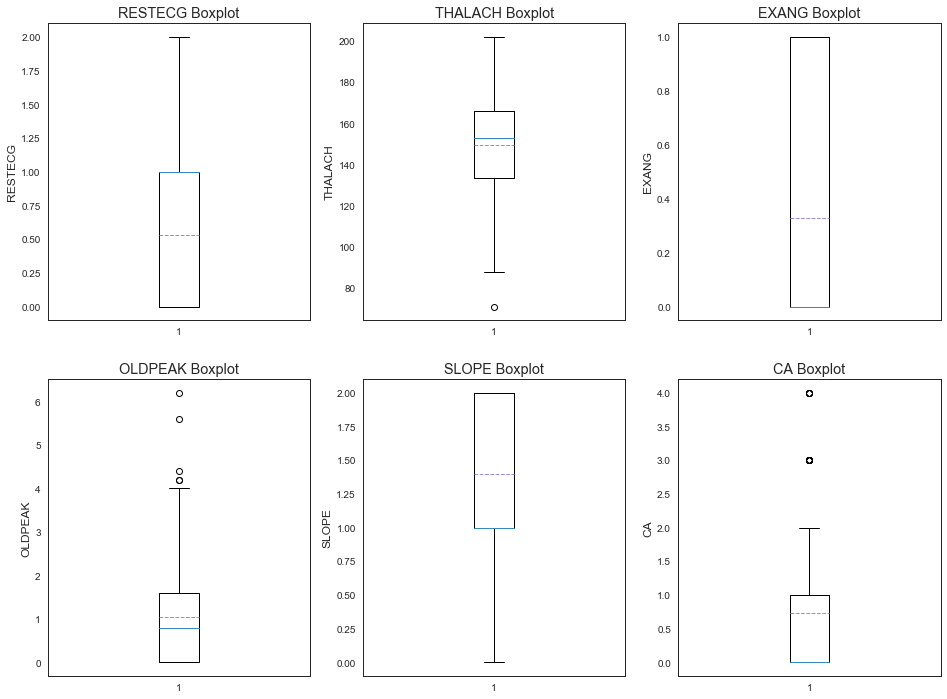

In [51]:
#graph distribution of quantitative data
plt.figure(figsize=[16,12])

i=0
for col in hdata.columns[6:12]: #[input index of desired columns]
#     if hdata[col].nunique() < 5 and col != 'target':
    i += 1
    plt.subplot(230+i)
    plt.boxplot(x=hdata[col], showmeans = True, meanline = True)
    plt.title('{} Boxplot'.format(col.upper()))
    plt.ylabel('{}'.format(col.upper()))

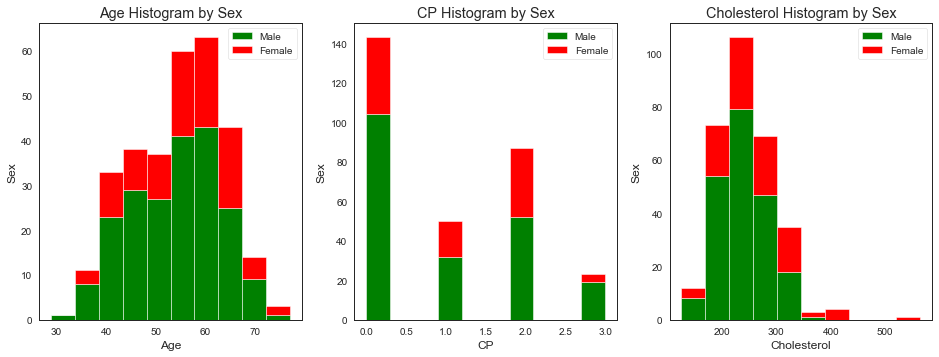

In [23]:
#graph distribution of quantitative data
plt.figure(figsize=[16,12])

plt.subplot(231)
plt.hist(x = [hdata[hdata['sex']==1]['age'], hdata[hdata['sex']==0]['age']], 
         stacked=True, color = ['g','r'],label = ['Male','Female'])
plt.title('Age Histogram by Sex')
plt.xlabel('Age')
plt.ylabel('Sex')
plt.legend()

plt.subplot(232)
plt.hist(x = [hdata[hdata['sex']==1]['cp'], hdata[hdata['sex']==0]['cp']], 
         stacked=True, color = ['g','r'],label = ['Male','Female'])
plt.title('CP Histogram by Sex')
plt.xlabel('CP')
plt.ylabel('Sex')
plt.legend()

plt.subplot(233)
plt.hist(x = [hdata[hdata['sex']==1]['chol'], hdata[hdata['sex']==0]['chol']], 
         stacked=True, color = ['g','r'],label = ['Male','Female'])
plt.title('Cholesterol Histogram by Sex')
plt.xlabel('Cholesterol')
plt.ylabel('Sex')
plt.legend();

In [24]:
hdata.nunique()>2

age          True
sex         False
cp           True
trestbps     True
chol         True
fbs         False
restecg      True
thalach      True
exang       False
oldpeak      True
slope        True
ca           True
thal         True
target      False
age_bin      True
dtype: bool

In [62]:
# thal column doesn't make sense, the info given in dataset description is either wrong or incomplete
hdata.loc[hdata.thal==0]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,age_bin
48,53,0,2,128,216,0,0,115,0,0.0,2,0,0,1,"(50, 60]"
281,52,1,0,128,204,1,1,156,1,1.0,1,0,0,0,"(50, 60]"


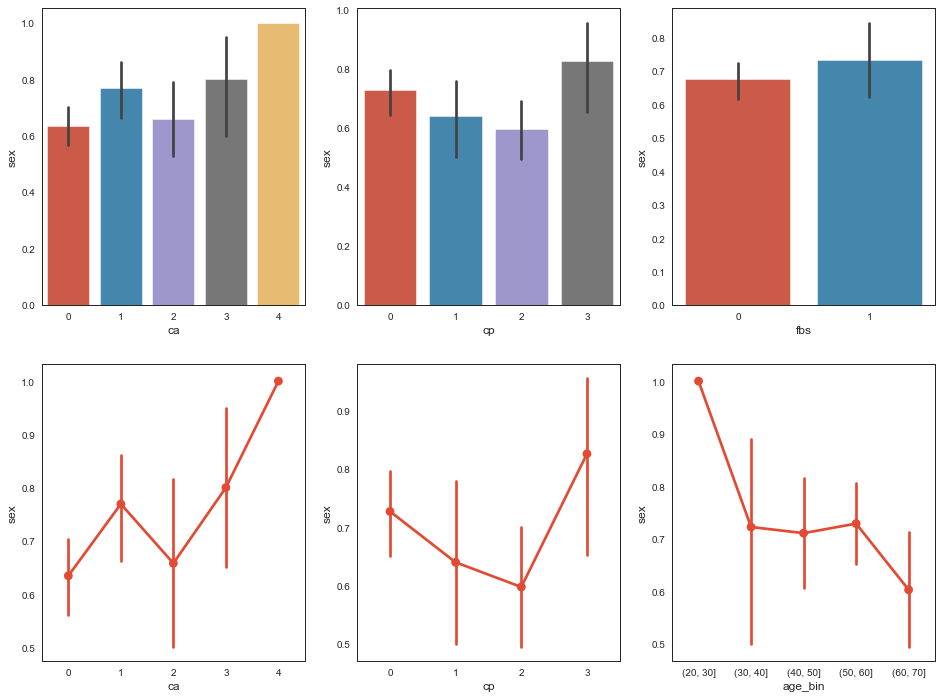

In [64]:
#we will use seaborn graphics for multi-variable comparison: https://seaborn.pydata.org/api.html

#graph individual features by survival
fig, saxis = plt.subplots(2, 3,figsize=(16,12))

sns.barplot(x = 'ca', y = 'sex', data=hdata, ax = saxis[0,0])
sns.barplot(x = 'cp', y = 'sex', order=[0,1,2,3], data=hdata, ax = saxis[0,1])
sns.barplot(x = 'fbs', y = 'sex', order=[0,1], data=hdata, ax = saxis[0,2])

sns.pointplot(x = 'ca', y = 'sex',  data=hdata, ax = saxis[1,0])
sns.pointplot(x = 'cp', y = 'sex',  data=hdata, ax = saxis[1,1])
sns.pointplot(x = 'age_bin', y = 'sex', data=hdata, ax = saxis[1,2])

Text(0.5, 1.0, 'Slope vs Age Target Comparison')

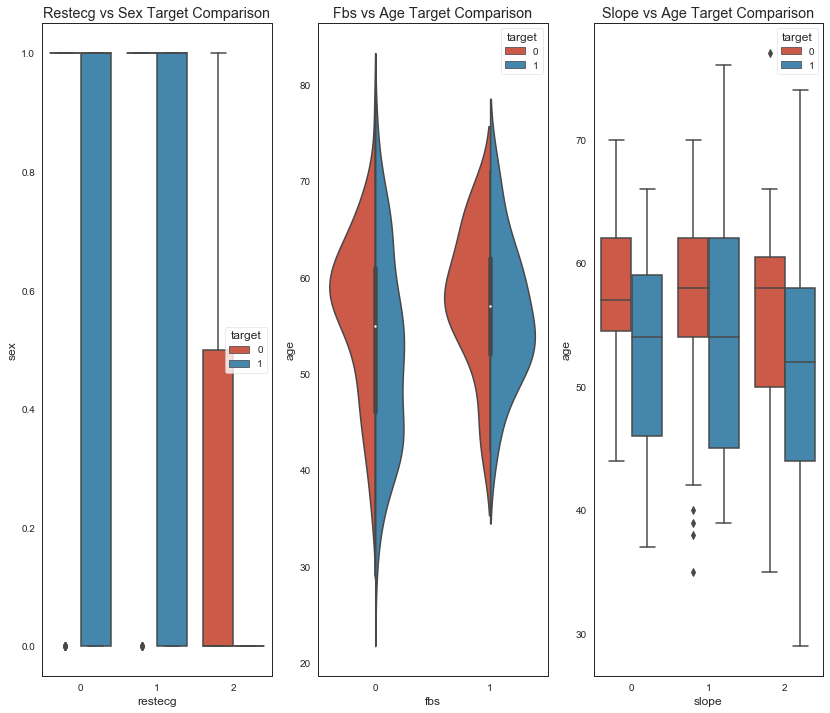

In [82]:
#graph distribution of qualitative data: Pclass
#we know class mattered in survival, now let's compare class and a 2nd feature
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(14,12))

# this one doesn't make sense to me
sns.boxplot(x = 'restecg', y = 'sex', hue = 'target', data = hdata, ax = axis1)
axis1.set_title('Restecg vs Sex Target Comparison')

sns.violinplot(x = 'fbs', y = 'age', hue = 'target', data = hdata, split = True, ax = axis2)
axis2.set_title('Fbs vs Age Target Comparison')

sns.boxplot(x = 'slope', y ='age', hue = 'target', data = hdata, ax = axis3)
axis3.set_title('Slope vs Age Target Comparison')

In [83]:
# #more side-by-side comparisons
# fig, (maxis1, maxis2) = plt.subplots(1, 2,figsize=(14,12))

# #how does cp factor with sex & target compare
# sns.pointplot(x="cp", y="target", hue="sex", data=hdata,
#               palette={"male": "blue", "female": "pink"},
#               markers=["*", "o"], linestyles=["-", "--"], ax = maxis1)

# #how does fbs factor with sex & target compare
# sns.pointplot(x="fbs", y="target", hue="sex", data=hdata,
#               palette={"1": "blue", "0": "pink"},
#               markers=["*", "o"], linestyles=["-", "--"], ax = maxis2)

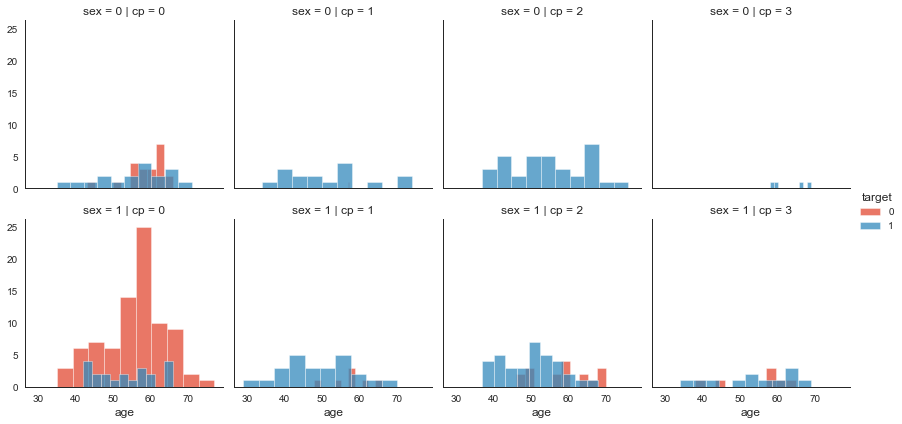

In [84]:
#histogram comparison of sex, class, and age by survival
h = sns.FacetGrid(hdata, row = 'sex', col = 'cp', hue = 'target')
h.map(plt.hist, 'age', alpha = .75)
h.add_legend()

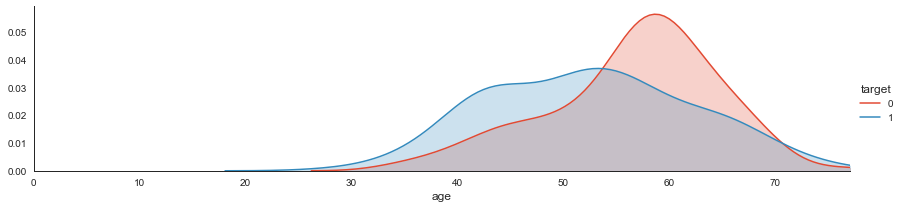

In [70]:
#plot distributions of ages of patients
a = sns.FacetGrid(hdata, hue = 'target', aspect=4 )
a.map(sns.kdeplot, 'age', shade= True )
a.set(xlim=(0 , hdata['age'].max()))
a.add_legend()

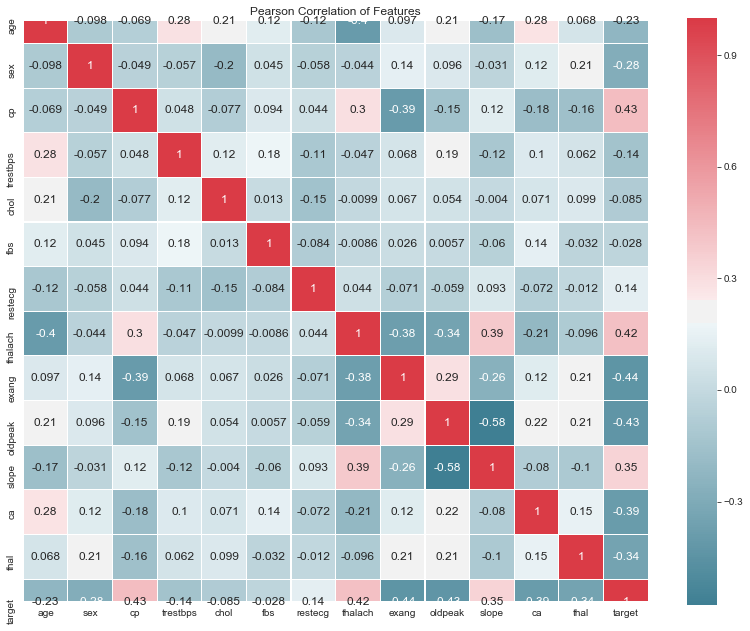

In [26]:
#correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9}, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12}
                    )
    
    plt.title('Pearson Correlation of Features', y=1, size=12)

correlation_heatmap(hdata)